In [1]:
import keras

Using TensorFlow backend.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [3]:
import librosa

In [4]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [5]:
features=[]

def extract_features(file_name):
    try:
        y, sr = librosa.load(file_name, mono=True,res_type='kaiser_fast')
        mfccs=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40)
        mfccscaled=np.mean(mfccs.T,axis=0)
    except Exception as e:
        print("Error Encountered while parsing file",file)
        return None
    
    return mfccscaled
        
        
for g in genres:
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        dat=extract_features(songname)
        features.append([dat,g])
featuresdf=pd.DataFrame(features,columns=['feature','g'])
print('Finished feature extraction from ', len(featuresdf), ' files')    
featuresdf.shape

Finished feature extraction from  1000  files


(1000, 2)

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.g.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
np.savetxt("firstarray.csv", X, delimiter=",")

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM,BatchNormalization
from keras.layers import Convolution1D, Conv1D, MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 20
num_columns = 2

num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns)

num_labels = yy.shape[1]
filter_size=1
# Construct model 
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, input_shape=(num_rows, num_columns), activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.25))
model.add(AveragePooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.25))
model.add(AveragePooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.25))
model.add(AveragePooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))


model.add(Dense(num_labels, activation='softmax'))


In [25]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 19, 32)            160       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 19, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 18, 64)            0         
__________

In [26]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 800 samples, validate on 200 samples
Epoch 1/72
800/800 [==============================] - 6s 8ms/step - loss: 3.4142 - acc: 0.1350 - val_loss: 2.0538 - val_acc: 0.2100

Epoch 00001: val_loss improved from inf to 2.05377, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 2/72
800/800 [==============================] - 2s 2ms/step - loss: 2.3520 - acc: 0.2275 - val_loss: 2.0134 - val_acc: 0.2400

Epoch 00002: val_loss improved from 2.05377 to 2.01338, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 3/72
800/800 [==============================] - 2s 2ms/step - loss: 2.1558 - acc: 0.2575 - val_loss: 1.9787 - val_acc: 0.2950

Epoch 00003: val_loss improved from 2.01338 to 1.97867, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 4/72
800/800 [==============================] - 2s 2ms/step - loss: 2.0263 - acc: 0.3012 - val_loss: 1.9413 - val_acc: 0.3050

Epoch 00004: val_loss improved from 1.97867 to 1.94131, saving model to saved_models/we

Epoch 37/72
800/800 [==============================] - 3s 4ms/step - loss: 0.9975 - acc: 0.6512 - val_loss: 1.2653 - val_acc: 0.5600

Epoch 00037: val_loss improved from 1.28062 to 1.26529, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 38/72
800/800 [==============================] - 2s 2ms/step - loss: 1.0131 - acc: 0.6438 - val_loss: 1.2588 - val_acc: 0.5600

Epoch 00038: val_loss improved from 1.26529 to 1.25876, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 39/72
800/800 [==============================] - 2s 2ms/step - loss: 0.9827 - acc: 0.6575 - val_loss: 1.2713 - val_acc: 0.5650

Epoch 00039: val_loss did not improve from 1.25876
Epoch 40/72
800/800 [==============================] - 2s 2ms/step - loss: 0.9560 - acc: 0.6700 - val_loss: 1.2610 - val_acc: 0.5650

Epoch 00040: val_loss did not improve from 1.25876
Epoch 41/72
800/800 [==============================] - 2s 2ms/step - loss: 0.9561 - acc: 0.6462 - val_loss: 1.2777 - val_acc: 0.5500

Ep

In [27]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.92375
Testing Accuracy:  0.575


In [28]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

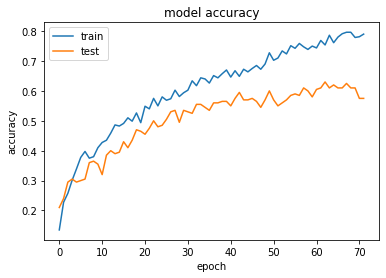

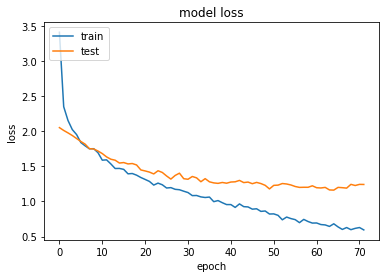

In [29]:
# Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [17]:
spect.shape

(128, 1293)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import librosa


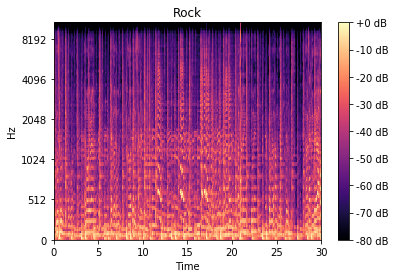

In [3]:
import librosa.display
y, sr = librosa.load('rock.00003.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Rock');
plt.colorbar(format='%+2.0f dB');

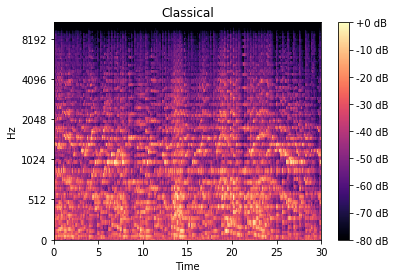

In [5]:
y, sr = librosa.load('genres\classical\classical.00000.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Classical');
plt.colorbar(format='%+2.0f dB');

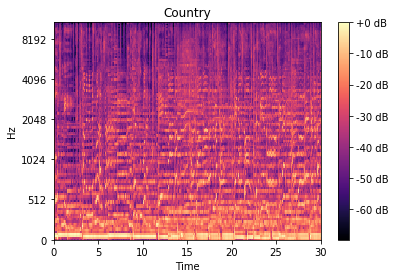

In [11]:
y, sr = librosa.load('genres\country\country.00000.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Country');
plt.colorbar(format='%+2.0f dB');

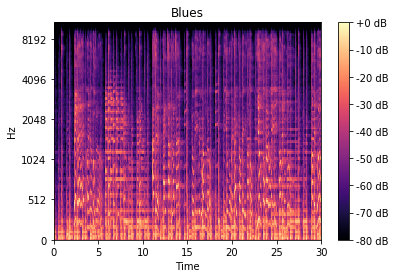

In [15]:
y, sr = librosa.load('blues.00001.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Blues');
plt.colorbar(format='%+2.0f dB');

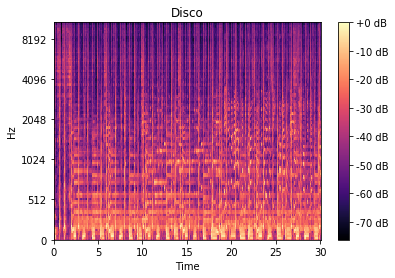

In [17]:
y, sr = librosa.load('genres\disco\disco.00000.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Disco');
plt.colorbar(format='%+2.0f dB');

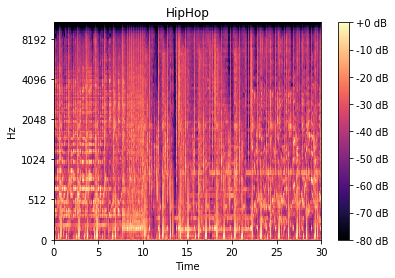

In [18]:
y, sr = librosa.load('genres\hiphop\hiphop.00000.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('HipHop');
plt.colorbar(format='%+2.0f dB');

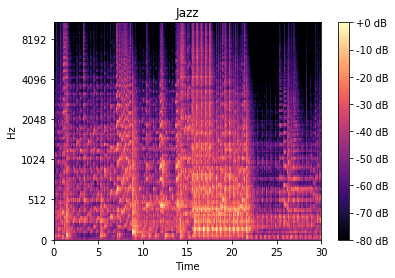

In [19]:
y, sr = librosa.load('genres\jazz\jazz.00000.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Jazz');
plt.colorbar(format='%+2.0f dB');

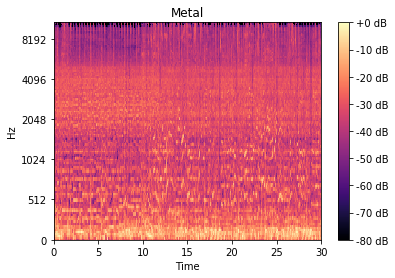

In [20]:
y, sr = librosa.load('genres\metal\metal.00000.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Metal');
plt.colorbar(format='%+2.0f dB');

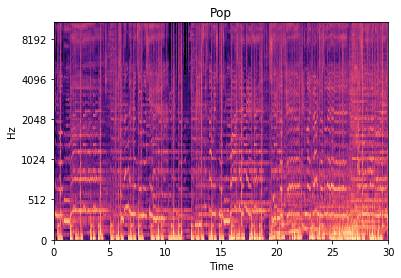

In [21]:
y, sr = librosa.load('genres\pop\pop.00000.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Pop');

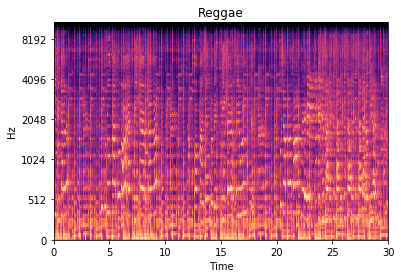

In [26]:
y, sr = librosa.load('reggae.00000.au')
n_mels = 128
hop_length=512
n_fft=2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.title('Reggae');